# Imports

In [77]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing

# Input

Number of nodes: 8
Number of edges: 18


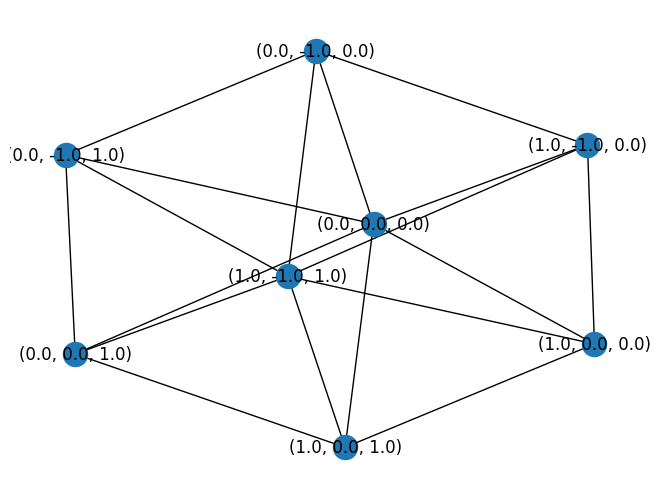

In [78]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/cube.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=True, display_labels=True)

# Point Sampler

### DevConv

In [80]:
class DevConv():
    def __init__(self, graph):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.array([0.1])      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, is_relu=True):
        list_inc_score_before_function = np.zeros(shape=(len(self.list_node)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node)))   # norm(W_theta * (xi - xj))
            # print(neigh_distances)
            list_inc_score_before_function[index_current_node] = self.W_phi[0] * np.max(neigh_distances)
            # print(list_inc_score_before_function)

        # apply non linear function
        if is_relu:
            list_inc_score = np.maximum(list_inc_score_before_function, 0)
        else:
            list_inc_score = 1 / (1 + np.exp(-list_inc_score_before_function))

        # merge with previous inclusion score
        if previous_inclusion_score!=None:
            return np.mean(previous_inclusion_score, list_inc_score)
        return list_inc_score

In [81]:
devconv = DevConv(graph)
inclusion_score = devconv.forward(previous_inclusion_score=None, is_relu=False)
print(inclusion_score)

[0.58917481 0.57840466 0.58917481 0.57444252 0.58917481 0.57840466
 0.58917481 0.57444252]


### Multinomial Sampling

In [82]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[59 65 65 60 73 53 60 65]


In [86]:
K = 5   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -K)[-K:]
list_k_nodes = np.fromiter(graph._node.keys(), dtype=tuple)[index_k_nodes]
print(list_k_nodes)

[(0.0, 0.0, 1.0) (0.0, -1.0, 1.0) (1.0, 0.0, 1.0) (1.0, 0.0, 0.0)
 (1.0, -1.0, 0.0)]


# KNN

# Edge Predictor

In [ ]:
#devconv

### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh